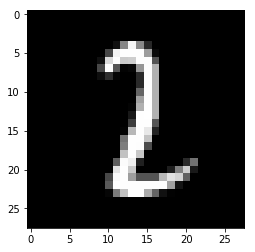

In [1]:
# Import necessary modules
import torch 
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
%matplotlib inline


# Setting the transfomation pipeline each of the image has to go through
transform = transforms.Compose([transforms.ToTensor(), 
                               transforms.Normalize([0.5], [0.5])
                               ])

# Setting training set and testing set
trainset = datasets.MNIST('~/.pytorch/Fashion-MNIST/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/Fashion-MNIST/', download=True, train=False, transform=transform)

# Define the validation set size
validSize = 0.2

numTrain = len(trainset)
indices = list(range(numTrain))
np.random.shuffle(indices)
splitPoint = int(np.floor(numTrain*validSize))
trainIdx, validIdx = indices[splitPoint:], indices[:splitPoint]


# Defining iterators for training and testing data
numWorkers = 0
batchSize = 64
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, sampler=SubsetRandomSampler(trainIdx), 
                                          num_workers=numWorkers)
validLoader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, sampler=SubsetRandomSampler(validIdx), 
                                          num_workers=numWorkers)
testLoader = torch.utils.data.DataLoader(testset, batch_size = batchSize, shuffle=True,
                                        num_workers=numWorkers)


# Testing if the iterator is working
images, labels = next(iter(trainLoader))
plt.imshow(images[9,:].view(28,28), cmap='gray')

In [16]:
softmax = nn.LogSoftmax(dim=1)

dropout = nn.Dropout(p=0.2)

criterion= nn.NLLLoss()


def trainAndTestModels(modelDict):
    print("Architechture details :", modelDict['name'], '\n')
    
    model = modelDict['model']

    # Defining the optimizer for training the network. SGD refers to stochastic gradient descent.
    optimizer = optim.SGD(model.parameters(), lr = 0.02)

    # Epochs refers to the numbers of iterations through the whole data
    epochs = 50
    validLossMin = np.inf

    trainingLosses = []
    validLosses = []

    for e in range(epochs):
        # Training
        trainingLoss = 0
        validLoss = 0

        model.train()

        for images, labels in trainLoader:

            # Changing images inputs to 2d matrices with number of rows as number of images in each iteration and each row 
            # vector representing a flattened image
            images = images.view(images.shape[0], -1)

            optimizer.zero_grad()

            # Calculating the log softmax probabilities
            logps = model(images)

            # Calculating the loss
            loss = criterion(logps, labels)

            # Calculating the gradients
            loss.backward()

            # Updating the weights
            optimizer.step()

            # Updating the training loss
            trainingLoss += loss.item()*images.shape[0]



        trainingLoss = trainingLoss/len(trainLoader.dataset)
        trainingLosses.append(trainingLoss)

        model.eval()

        for images, labels in validLoader:
            with torch.no_grad():
                # Read comments from the training loop
                images = images.view(images.shape[0], -1)

                logps = model(images)

                loss = criterion(logps, labels)

            validLoss += loss.item()*images.shape[0]

        validLoss = validLoss/len(validLoader.dataset)
        validLosses.append(validLoss)

        print("Epoch Number :", e+1, ", Training Loss :", trainingLoss, ", Validation Loss :", validLoss)

        if validLoss <= validLossMin:
            print("Validation loss decreased from", validLossMin, 'to', validLoss,"Saving model....\n")
            validLossMin = validLoss
            torch.save(model.state_dict(), "model.pt")
            
            
            
    # Load the last saved model
    
    model.load_state_dict(torch.load('model.pt'))

    # Testing the model       

    correctCases = [0 for i in range(10)]
    totalCases = [0 for i in range(10)]

    testLoss = 0

    for images, labels in testLoader:

        optimizer.zero_grad()

        images = images.view(images.shape[0], -1)

        logps = model(images)

        loss = criterion(logps, labels)

        testLoss += loss.item()*images.shape[0]

        ps = torch.exp(logps) 

        topP, topClass = ps.topk(1, dim=1)

        equality = topClass == labels.view(*topClass.shape)

        for i in range(len(labels)):
            label = labels[i]
            correctCases[label] += equality[i].item()
            totalCases[label] +=1

    testLoss = testLoss/len(testLoader.dataset)

    print("Test Loss :", testLoss, '\n')

    for label in range(10):
        print("Accuracy for label", label, ":", str(round((100.0*correctCases[label])/totalCases[label],3)) + "%")
    else:
        print("\nOverall accuracy: ", str(round((100.0*np.sum(correctCases))/np.sum(totalCases),3)) + "%")
        
    fig, ax = plt.subplots()   
    ax.plot(trainingLosses, label='Training Loss')
    ax.plot(validLosses, label='Validation Loss')
    ax.set_title(modelDict['name'])
    ax.legend(frameon=False)
    plt.show()
    
    print("--------------------------------------------\n")
    



Architechture details : No hidden layer NN 

Epoch Number : 1 , Training Loss : 0.797559707959493 , Validation Loss : 0.12438388681411743
Validation loss decreased from inf to 0.12438388681411743 Saving model....

Epoch Number : 2 , Training Loss : 0.44106885159810383 , Validation Loss : 0.09901184959411621
Validation loss decreased from 0.12438388681411743 to 0.09901184959411621 Saving model....

Epoch Number : 3 , Training Loss : 0.37598471523920696 , Validation Loss : 0.08884794193903606
Validation loss decreased from 0.09901184959411621 to 0.08884794193903606 Saving model....

Epoch Number : 4 , Training Loss : 0.3446929423967997 , Validation Loss : 0.08320072744687398
Validation loss decreased from 0.08884794193903606 to 0.08320072744687398 Saving model....

Epoch Number : 5 , Training Loss : 0.3252516335805257 , Validation Loss : 0.07949717933336893
Validation loss decreased from 0.08320072744687398 to 0.07949717933336893 Saving model....

Epoch Number : 6 , Training Loss : 0.311

Epoch Number : 47 , Training Loss : 0.23116185539563497 , Validation Loss : 0.05967829311688741
Validation loss decreased from 0.05994818823337555 to 0.05967829311688741 Saving model....

Epoch Number : 48 , Training Loss : 0.23074419950644176 , Validation Loss : 0.05963244590759277
Validation loss decreased from 0.05967829311688741 to 0.05963244590759277 Saving model....

Epoch Number : 49 , Training Loss : 0.23019102722803753 , Validation Loss : 0.059600448020299276
Validation loss decreased from 0.05963244590759277 to 0.059600448020299276 Saving model....

Epoch Number : 50 , Training Loss : 0.22975877995491029 , Validation Loss : 0.0598339032014211
Test Loss : 0.28607287874221804 

Accuracy for label 0 : 97.551%
Accuracy for label 1 : 97.709%
Accuracy for label 2 : 89.341%
Accuracy for label 3 : 90.693%
Accuracy for label 4 : 93.381%
Accuracy for label 5 : 85.65%
Accuracy for label 6 : 94.572%
Accuracy for label 7 : 91.44%
Accuracy for label 8 : 87.782%
Accuracy for label 9 : 88.99

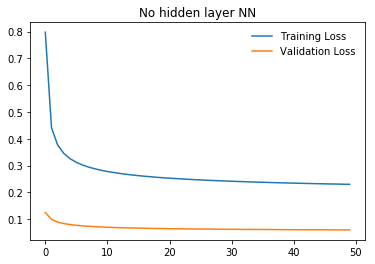

--------------------------------------------

Architechture details : 1-hidden layer NN 

Epoch Number : 1 , Training Loss : 1.2557621660232543 , Validation Loss : 0.18652479387919108
Validation loss decreased from inf to 0.18652479387919108 Saving model....

Epoch Number : 2 , Training Loss : 0.6446356567064921 , Validation Loss : 0.11898152917226155
Validation loss decreased from 0.18652479387919108 to 0.11898152917226155 Saving model....

Epoch Number : 3 , Training Loss : 0.49093687270482383 , Validation Loss : 0.0970291489760081
Validation loss decreased from 0.11898152917226155 to 0.0970291489760081 Saving model....

Epoch Number : 4 , Training Loss : 0.421727853123347 , Validation Loss : 0.08614849769274394
Validation loss decreased from 0.0970291489760081 to 0.08614849769274394 Saving model....

Epoch Number : 5 , Training Loss : 0.38799070655504864 , Validation Loss : 0.0796584376335144
Validation loss decreased from 0.08614849769274394 to 0.0796584376335144 Saving model....



Epoch Number : 45 , Training Loss : 0.1820892362833023 , Validation Loss : 0.039094255562623345
Validation loss decreased from 0.0394641995827357 to 0.039094255562623345 Saving model....

Epoch Number : 46 , Training Loss : 0.18121535438696543 , Validation Loss : 0.03868710068066915
Validation loss decreased from 0.039094255562623345 to 0.03868710068066915 Saving model....

Epoch Number : 47 , Training Loss : 0.1803454930305481 , Validation Loss : 0.03844071392218272
Validation loss decreased from 0.03868710068066915 to 0.03844071392218272 Saving model....

Epoch Number : 48 , Training Loss : 0.17828478385607402 , Validation Loss : 0.03805062070687612
Validation loss decreased from 0.03844071392218272 to 0.03805062070687612 Saving model....

Epoch Number : 49 , Training Loss : 0.1762699585358302 , Validation Loss : 0.037545050021012626
Validation loss decreased from 0.03805062070687612 to 0.037545050021012626 Saving model....

Epoch Number : 50 , Training Loss : 0.17378576384385427 , V

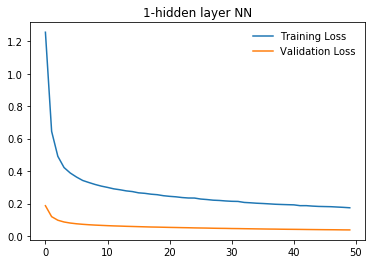

--------------------------------------------

Architechture details : 4 hidden layers NN 

Epoch Number : 1 , Training Loss : 1.8144364969889324 , Validation Loss : 0.4389140941619873
Validation loss decreased from inf to 0.4389140941619873 Saving model....

Epoch Number : 2 , Training Loss : 1.6594712760925292 , Validation Loss : 0.3563836031595866
Validation loss decreased from 0.4389140941619873 to 0.3563836031595866 Saving model....

Epoch Number : 3 , Training Loss : 1.2870858753204346 , Validation Loss : 0.2340016668319702
Validation loss decreased from 0.3563836031595866 to 0.2340016668319702 Saving model....

Epoch Number : 4 , Training Loss : 0.9519920110702514 , Validation Loss : 0.1670190235455831
Validation loss decreased from 0.2340016668319702 to 0.1670190235455831 Saving model....

Epoch Number : 5 , Training Loss : 0.7773489234924317 , Validation Loss : 0.1373790469487508
Validation loss decreased from 0.1670190235455831 to 0.1373790469487508 Saving model....

Epoch Num

Epoch Number : 45 , Training Loss : 0.17753605876763662 , Validation Loss : 0.03047530046304067
Epoch Number : 46 , Training Loss : 0.17738904125293095 , Validation Loss : 0.029488626511891682
Validation loss decreased from 0.030317551072438557 to 0.029488626511891682 Saving model....

Epoch Number : 47 , Training Loss : 0.172852472670873 , Validation Loss : 0.02934228089253108
Validation loss decreased from 0.029488626511891682 to 0.02934228089253108 Saving model....

Epoch Number : 48 , Training Loss : 0.1707461143374443 , Validation Loss : 0.029084361724058788
Validation loss decreased from 0.02934228089253108 to 0.029084361724058788 Saving model....

Epoch Number : 49 , Training Loss : 0.16970857588450114 , Validation Loss : 0.02832944614092509
Validation loss decreased from 0.029084361724058788 to 0.02832944614092509 Saving model....

Epoch Number : 50 , Training Loss : 0.16404255707263946 , Validation Loss : 0.028212424087524415
Validation loss decreased from 0.02832944614092509 

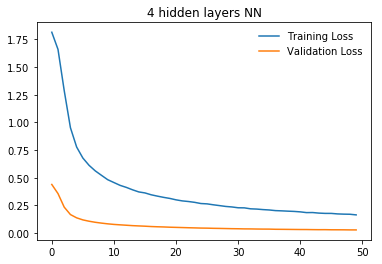

--------------------------------------------



In [17]:
# Define your models here 

# Model1: No hidden layer 
m1 = {'name': 'No hidden layer NN' , 'model': nn.Sequential(nn.Linear(28*28, 10), softmax)}


# Model2: 1 hidden layer
m2 = {'name': "1-hidden layer NN", 'model':  nn.Sequential(nn.Linear(28*28, 64), nn.ReLU(), dropout, 
                                                           nn.Linear(64, 10), softmax)
     }


# Model3 : 4 hidden layers
m3 = {'name': '4 hidden layers NN', 'model': nn.Sequential(nn.Linear(28*28,128), nn.ReLU(),dropout, 
                                                           nn.Linear(128, 64),nn.ReLU(), dropout, 
                                                           nn.Linear(64, 32), nn.ReLU(), dropout,
                                                           nn.Linear(32, 10), softmax)
     }

models = [m1, m2, m3]


for model in models:
    trainAndTestModels(model)
    
    

In [ ]:



images, labels = next(iter(testLoader))
idx = 5
image = images[idx]
with torch.no_grad():
    logps = model(images[idx].view(1, -1))
    ps = torch.exp(logps)

plt.imshow(image.view(28, 28), cmap='gray')        
plt.title("Correct label : " + str(labels[idx].item()) + ", Predicted label : "+ str(torch.argmax(ps).item()))